Data shape after preprocessing: (301059, 30)
   Transaction_ID  Customer_ID                 Name                Email  \
0       8691788.0      37249.0  Michelle Harrington    Ebony39@gmail.com   
1       2174773.0      69749.0          Kelsey Hill     Mark36@gmail.com   
2       6679610.0      30192.0         Scott Jensen    Shane85@gmail.com   
3       7232460.0      62101.0        Joseph Miller     Mary34@gmail.com   
4       4983775.0      27901.0        Debra Coleman  Charles30@gmail.com   

          Phone                      Address        City            State  \
0  1.414787e+09            3959 Amanda Burgs    Dortmund           Berlin   
1  6.852900e+09           82072 Dawn Centers  Nottingham          England   
2  8.362160e+09            4133 Young Canyon     Geelong  New South Wales   
3  2.776752e+09  8148 Thomas Creek Suite 100    Edmonton          Ontario   
4  9.098268e+09    5813 Lori Ports Suite 269     Bristol          England   

   Zipcode    Country  ...  Total_A

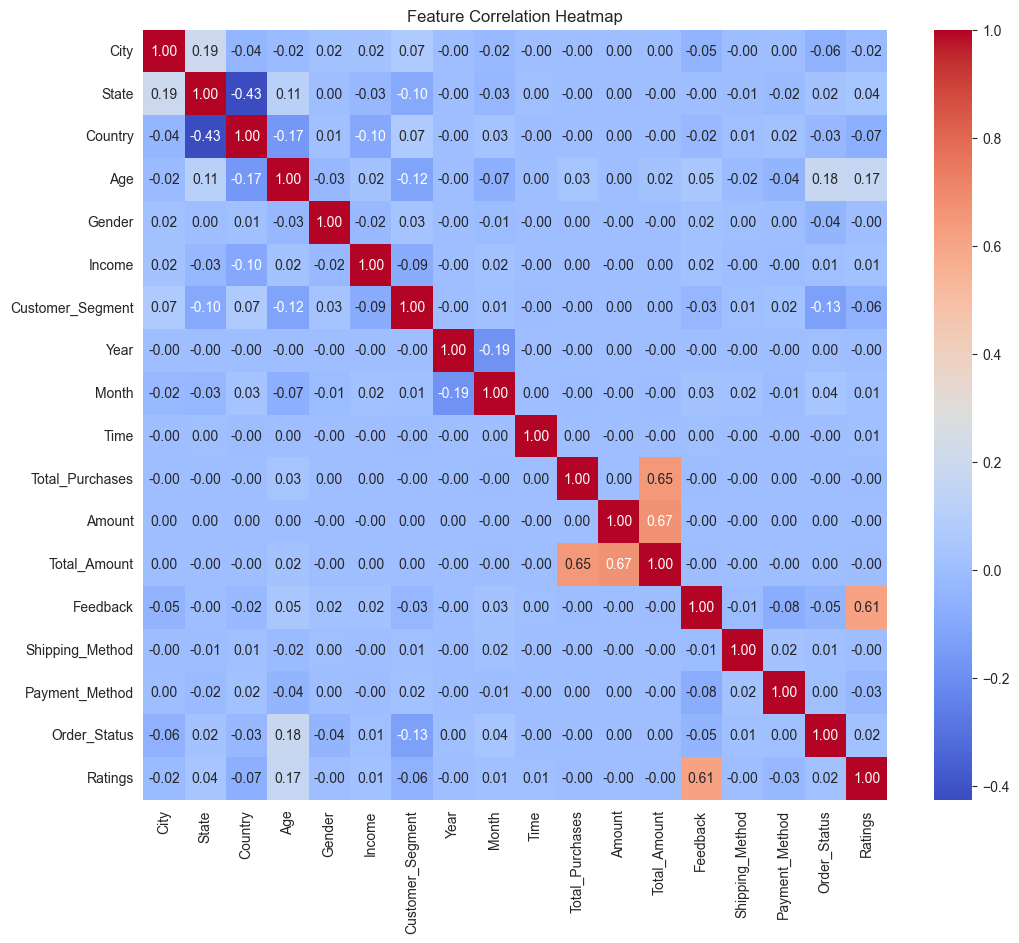

Train class distribution:
 Product_Category
Electronics    56821
Grocery        53310
Clothing       43700
Books          43618
Home Decor     43398
Name: count, dtype: int64
Test class distribution:
 Product_Category
Electronics    14205
Grocery        13328
Clothing       10925
Books          10904
Home Decor     10850
Name: count, dtype: int64
Resampled training class distribution:
 Product_Category
Clothing       56821
Electronics    56821
Books          56821
Grocery        56821
Home Decor     56821
Name: count, dtype: int64

Confusion Matrix:
 [[2616 2990 1312 1371 2615]
 [2560 3133 1323 1409 2500]
 [2623 2997 4578 1493 2514]
 [2517 3085 1301 3903 2522]
 [2444 3106 1266 1452 2582]]

Classification Report:
               precision    recall  f1-score   support

       Books       0.21      0.24      0.22     10904
    Clothing       0.20      0.29      0.24     10925
 Electronics       0.47      0.32      0.38     14205
     Grocery       0.41      0.29      0.34     13328
  Home

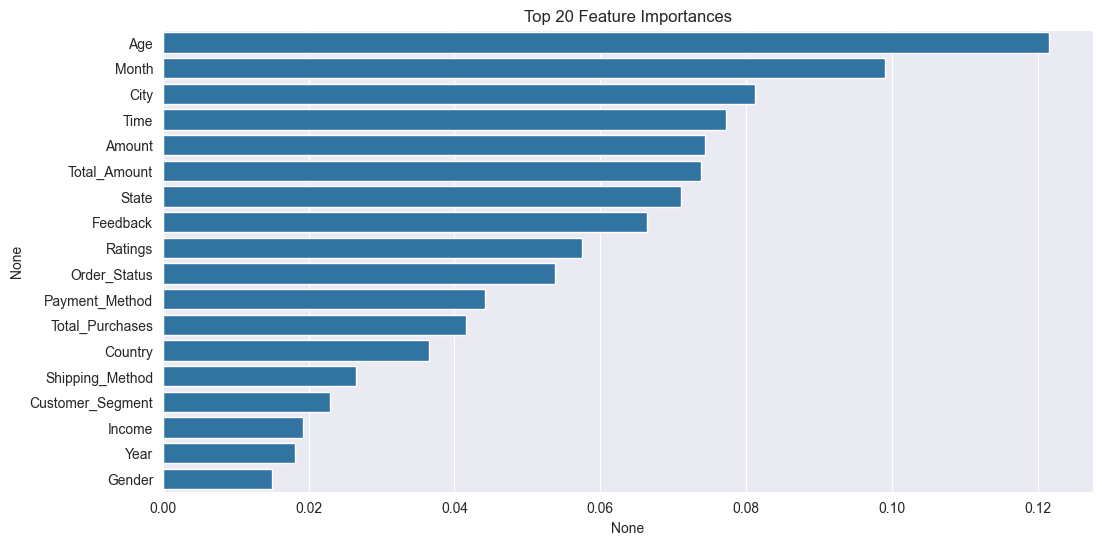

In [3]:
# 1️⃣ Import Libraries
#----------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 2️⃣ Load Dataset
#----------------------------
df = pd.read_csv("../data/raw/data.csv")
df = df.drop_duplicates()
df = df.dropna(subset=["Customer_ID", "Amount", "Product_Category"])
df = df.fillna({"Income": "Unknown", "Feedback": "No Feedback"})
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

print("Data shape after preprocessing:", df.shape)
print(df.head())

# 3️⃣ Feature Selection
#----------------------------
# Drop irrelevant columns (IDs, personal info, leakage)
drop_cols = [
    "Transaction_ID", "Customer_ID", "Name", "Email", "Phone",
    "Address", "Zipcode", "products", "Date", "Product_Brand", "Product_Type"
]
X = df.drop(columns=drop_cols + ["Product_Category"])
y = df["Product_Category"]

# 4️⃣ Handle Missing / Infinite Values
#----------------------------
X.replace([np.inf, -np.inf], np.nan, inplace=True)

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Numeric: fill with median
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
# Categorical: fill with mode
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

print("Any NaN left in X?", X.isna().sum().sum())

# 5️⃣ Encode Categorical Variables
#----------------------------
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

# 6️⃣ Feature Correlation Heatmap
#----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# 7️⃣ Train-Test Split
#----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# 8️⃣ SMOTE Oversampling
#----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Resampled training class distribution:\n", y_train_res.value_counts())

# 9️⃣ Feature Scaling (Optional)
#----------------------------
scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 10️⃣ Model Training
#----------------------------
clf = RandomForestClassifier(
    n_estimators=500,  # increase trees
    max_depth=15,  # limit depth to reduce overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_res, y_train_res)

# 11️⃣ Evaluation
#----------------------------
y_pred = clf.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 12️⃣ Feature Importance Plot
#----------------------------
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[:20], y=importances[:20].index)
plt.title("Top 20 Feature Importances")
plt.show()


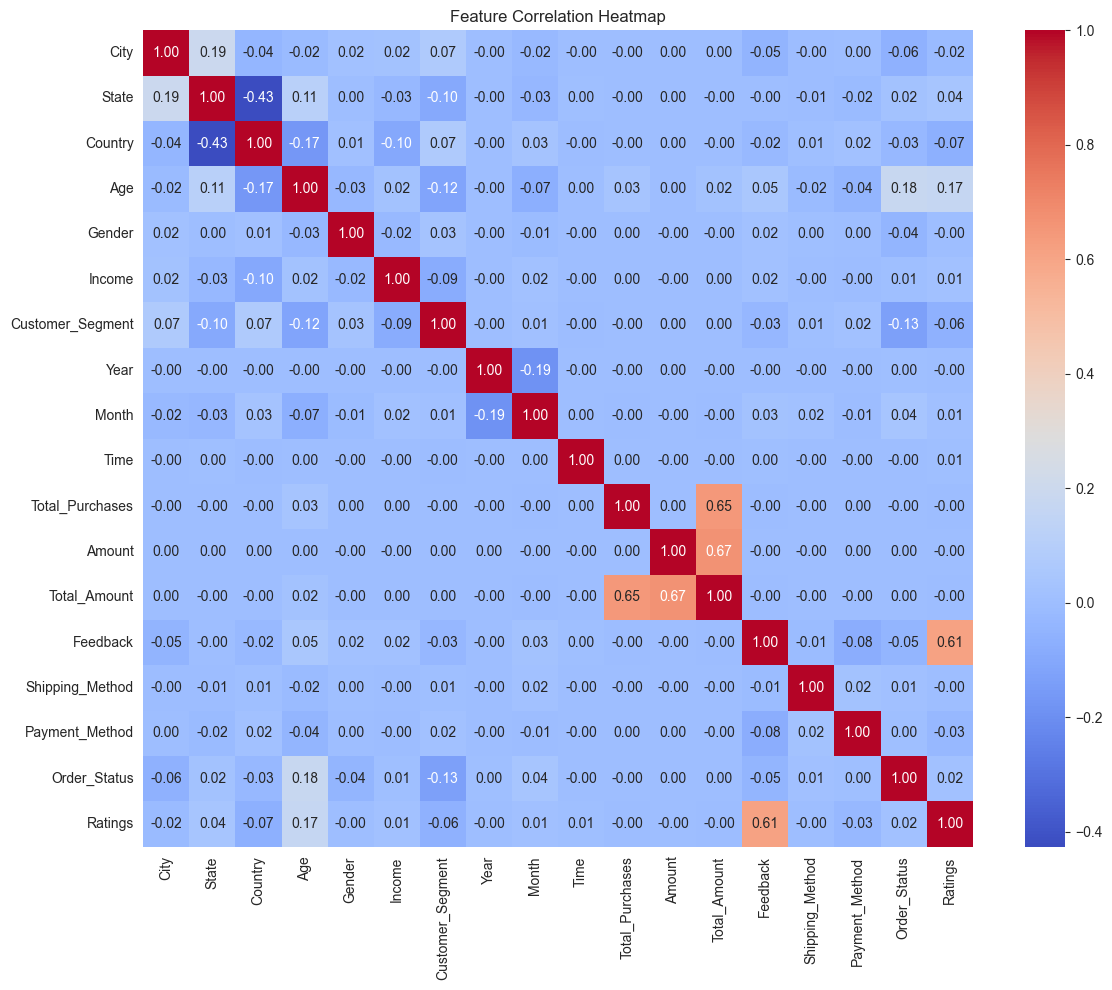

Heatmap saved as 'feature_correlation_heatmap.png'


In [5]:
# 6️⃣ Feature Correlation Heatmap (with download)
#----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")

# Save the heatmap as PNG
plt.tight_layout()  # ensures labels and title fit
plt.savefig("feature_correlation_heatmap.png", dpi=300)  # saved in current directory

plt.show()

print("Heatmap saved as 'feature_correlation_heatmap.png'")
